# Deep Learning for Content-Based Filtering

Content-Based Filtering (CBF) is a recommendation system strategy that recommends items by comparing the content of the items and a user profile, with content being described in terms of several descriptors or terms that are inherent to the item. For instance, in a content-based movie recommendation system, the content of the movie (e.g., genre, director, actor, etc.) will be matched against a user's profile, and the best matching movies will be recommended.

The general steps for building a CBF recommendation system are:

- **Feature Extraction:** Extract features from the content. In our case, we can use genres and tags as features.
- **Profile Building:** Build a profile for each user based on their interactions with different items (movies in our case). This profile represents the user's preference.
- **Scoring:** Compute a score for items (movies) based on how well their features match the user's profile.
- **Recommendation:** Recommend items (movies) that have the highest scores.

## 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## 2. Movie Ratings Dataset
The data set is derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset. The dataset contains about 9000 movies and 600 users.

In [7]:
# Loading the datasets
movies_df = pd.read_csv('../data/movies.csv')
ratings_df = pd.read_csv('../data/ratings.csv')
tags_df = pd.read_csv('../data/tags.csv')

## 3. Data Preprocessing

In [9]:
# Splitting the genres into a list
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df['genres']

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [10]:
# Grouping tags by movieId and aggregating them into a list
tags_grouped = tags_df.groupby('movieId')['tag'].apply(list).reset_index()
tags_grouped

,movieId,tag
0,1,"[pixar, pixar, fun]"
1,2,"[fantasy, magic board game, Robin Williams, game]"
2,3,"[moldy, old]"
3,5,"[pregnancy, remake]"
4,7,[remake]
...,...,...
1567,183611,"[Comedy, funny, Rachel McAdams]"
1568,184471,"[adventure, Alicia Vikander, video game adapta..."
1569,187593,"[Josh Brolin, Ryan Reynolds, sarcasm]"
1570,187595,"[Emilia Clarke, star wars]"


In [11]:
# Merging the movies dataframe with the aggregated tags
movies_features_df = pd.merge(movies_df, tags_grouped, on='movieId', how='left')
movies_features_df

,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",NaN
4,5,Father of the Bride Part II (1995),[Comedy],"[pregnancy, remake]"
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",NaN
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",NaN
9739,193585,Flint (2017),[Drama],NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",NaN


In [12]:
# Filling NaN values in the tag column with empty lists
movies_features_df['tag'] = movies_features_df['tag'].apply(lambda x: x if isinstance(x, list) else [])
movies_features_df

,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[]
4,5,Father of the Bride Part II (1995),[Comedy],"[pregnancy, remake]"
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",[]
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",[]
9739,193585,Flint (2017),[Drama],[]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",[]


In [14]:
# Combining genres and tags into a single feature list
movies_features_df['features'] = movies_features_df['genres'] + movies_features_df['tag']
movies_features_df

,movieId,title,genres,tag,features
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, fun]","[Adventure, Animation, Children, Comedy, Fanta..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, magic board game, Robin Williams, game]","[Adventure, Children, Fantasy, fantasy, magic ..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old]","[Comedy, Romance, moldy, old]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[],"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy],"[pregnancy, remake]","[Comedy, pregnancy, remake]"
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",[],"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",[],"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama],[],[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",[],"[Action, Animation]"


In [15]:
# Checking for missing values in the datasets
missing_movies = movies_features_df.isnull().sum()
missing_ratings = ratings_df.isnull().sum()
missing_tags = tags_df.isnull().sum()

missing_movies, missing_ratings, missing_tags

(movieId     0
 title       0
 genres      0
 tag         0
 features    0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64,
 userId       0
 movieId      0
 tag          0
 timestamp    0
 dtype: int64)

## 4. Content-based Filtering with a Neural Network

### 4.1 - Training Data
For content-based filtering using a neural network, we need to construct our training data.
- **Input (X):** This would be the encoded features of movies. Since there are a lot of movies with a lot of different features, we'll reduce the number of features using a `dimensionality-reduction` library like [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Given that we've reduced the dimensionality, the input will be the reduced features of movies.
- **Output (Y):** The rating given by a user to a movie.

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD

In [17]:
# Encoding the features into a binary matrix
mlb = MultiLabelBinarizer()
movies_features_matrix = mlb.fit_transform(movies_features_df['features'])

In [18]:
movies_features_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# Applying TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=500)
reduced_features = svd.fit_transform(movies_features_matrix)

In [21]:
# Replacing the original movie features with the reduced ones
reduced_features_df = pd.DataFrame(reduced_features, index=movies_df.index)

# Constructing the training data
training_data = ratings_df.merge(reduced_features_df, left_on='movieId', right_index=True)

In [22]:
training_data

,userId,movieId,rating,timestamp,0,1,2,3,4,5,...,490,491,492,493,494,495,496,497,498,499
0,1,1,4.0,964982703,0.306855,0.238680,0.510972,0.952963,0.322504,-0.632030,...,0.035825,0.068444,-0.057703,0.002024,-0.016554,-0.086079,0.037277,0.103801,-0.135514,-0.043945
516,5,1,4.0,847434962,0.306855,0.238680,0.510972,0.952963,0.322504,-0.632030,...,0.035825,0.068444,-0.057703,0.002024,-0.016554,-0.086079,0.037277,0.103801,-0.135514,-0.043945
874,7,1,4.5,1106635946,0.306855,0.238680,0.510972,0.952963,0.322504,-0.632030,...,0.035825,0.068444,-0.057703,0.002024,-0.016554,-0.086079,0.037277,0.103801,-0.135514,-0.043945
1434,15,1,2.5,1510577970,0.306855,0.238680,0.510972,0.952963,0.322504,-0.632030,...,0.035825,0.068444,-0.057703,0.002024,-0.016554,-0.086079,0.037277,0.103801,-0.135514,-0.043945
1667,17,1,4.5,1305696483,0.306855,0.238680,0.510972,0.952963,0.322504,-0.632030,...,0.035825,0.068444,-0.057703,0.002024,-0.016554,-0.086079,0.037277,0.103801,-0.135514,-0.043945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99945,610,6095,3.5,1479542444,1.192847,0.292304,-0.466723,-0.059957,-0.290117,-0.278400,...,-0.000643,-0.000225,-0.000027,-0.000064,-0.000106,-0.000039,-0.000313,-0.000034,0.000402,-0.000242
100012,610,7202,3.0,1493848602,0.880787,1.016674,0.720437,0.812331,0.269551,-0.795382,...,0.000376,0.000522,0.000653,-0.000004,0.000163,-0.000072,-0.000339,-0.000358,-0.000223,0.000463
100033,610,7562,2.5,1479544865,1.330041,-0.950611,0.886171,-0.096362,0.192680,0.063500,...,-0.000899,-0.000036,-0.000165,0.000737,0.000027,0.000774,-0.000510,0.001778,0.000225,0.000068
100038,610,7984,4.0,1495959169,0.685221,-0.485248,-0.435989,0.180430,-0.118808,-0.170129,...,-0.000323,0.000176,-0.000216,-0.000127,0.000110,0.000038,-0.000445,-0.000225,0.000374,-0.000351


- **Input $X$:** This has a shape of (77939, 500), meaning we have 77,939 samples (user-movie pairs) and 500 features for each sample (the reduced features of movies).
- **Output $Y$:** This has a shape of (77939,), representing the ratings given by users to movies.

In [23]:
# Input features
X = training_data.iloc[:, 4:].values

# Output/target
Y = training_data['rating'].values

X.shape, Y.shape

((77939, 500), (77939,))

### 4.2 - Preparing the Training Data
For neural networks, it's essential to normalize the input data to ensure that all features have the same scale. This helps in faster convergence during training.

Below, we'll use the `StandardScaler` library from `sklearn` to scale our input data to have a mean of $0$ and a standard deviation of $1$.

In [24]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

# Fit the scaler and transform the input data
X_normalized = scaler.fit_transform(X)

X_normalized[:5]  # Display the first 5 normalized samples

array([[-1.17437174,  0.43797427,  0.85639806, ...,  6.65516425,
        -9.4444583 , -3.03849119],
       [-1.17437174,  0.43797427,  0.85639806, ...,  6.65516425,
        -9.4444583 , -3.03849119],
       [-1.17437174,  0.43797427,  0.85639806, ...,  6.65516425,
        -9.4444583 , -3.03849119],
       [-1.17437174,  0.43797427,  0.85639806, ...,  6.65516425,
        -9.4444583 , -3.03849119],
       [-1.17437174,  0.43797427,  0.85639806, ...,  6.65516425,
        -9.4444583 , -3.03849119]])

## 5. Neural Network Architecture

In this section, we'll design a neural network architecture suitable for regression since we're predicting ratings.

- **Input Layer:** Size of the reduced features (500 neurons/units)
- **Hidden Layers:** We'll use 2 hidden Dense layers with regularization.
- **Output Layer:** A single neuron (to predict the rating). Since ratings are continuous, we will use linear activation for the output layer.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_normalized.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               256512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 420865 (1.61 MB)
Trainable params: 420865 (1.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5.1 Model Training
We'll use a portion of the data as a validation set to monitor the validation loss and prevent overfitting.

In [26]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, Y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
975/975 [==============================] - 11s 10ms/step - loss: 1.3375 - mae: 0.9046 - val_loss: 1.1946 - val_mae: 0.8884
Epoch 2/20
975/975 [==============================] - 9s 10ms/step - loss: 1.1199 - mae: 0.8453 - val_loss: 1.1428 - val_mae: 0.8448
Epoch 3/20
975/975 [==============================] - 10s 10ms/step - loss: 1.1091 - mae: 0.8405 - val_loss: 1.1133 - val_mae: 0.8379
Epoch 4/20
975/975 [==============================] - 10s 10ms/step - loss: 1.0938 - mae: 0.8346 - val_loss: 1.1125 - val_mae: 0.8524
Epoch 5/20
975/975 [==============================] - 10s 10ms/step - loss: 1.0899 - mae: 0.8334 - val_loss: 1.0993 - val_mae: 0.8462
Epoch 6/20
975/975 [==============================] - 10s 10ms/step - loss: 1.0830 - mae: 0.8306 - val_loss: 1.1711 - val_mae: 0.8345
Epoch 7/20
975/975 [==============================] - 10s 10ms/step - loss: 1.0752 - mae: 0.8286 - val_loss: 1.1005 - val_mae: 0.8317
Epoch 8/20
975/975 [==============================] - 10s 10ms/

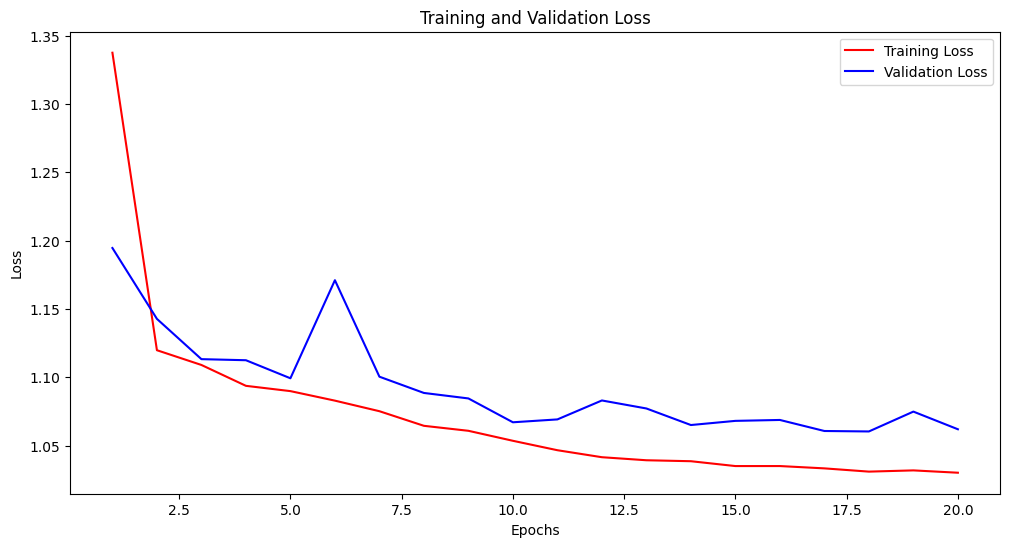

In [27]:
import matplotlib.pyplot as plt

# Extracting loss and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(12,6))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Predictions

With the trained model in hand, we can now make recommendations using Content-Based Filtering.

### 6.1 - Predictions for a new user
For a new user, we can use the neural network to recommend movies.

In [44]:
def get_recommendations_for_existing_user(user_id, model, X_normalized, movies_df, ratings_df):
    # Get movies already rated by this user
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    
    # Filter out rated movies from the dataset
    unrated_movies = movies_df[~movies_df['movieId'].isin(rated_movies)]
    
    # Predict ratings for unrated movies
    predicted_ratings = model.predict(X_normalized[unrated_movies.index])
    
    # Add predicted ratings to the unrated movies dataframe
    unrated_movies['predicted_rating'] = predicted_ratings
    
    # Return top 10 recommendations
    top_recommendations = unrated_movies[['title', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False).head(10)
    return top_recommendations

In [46]:
# Example: Get recommendations for user with ID 5
user_id = 50
print(get_recommendations_for_existing_user(user_id, model, X_normalized, movies_df, ratings_df))

295/295 [==============================] - 1s 3ms/step
                                       title  predicted_rating
2681                          Mr. Mom (1983)          4.228956
2550  Love Is a Many-Splendored Thing (1955)          4.228956
2553                  Thelma & Louise (1991)          4.228956
2554           ...And Justice for All (1979)          4.228956
2555                     Animal House (1978)          4.228956
2556              She's Gotta Have It (1986)          4.228956
2557                      School Daze (1988)          4.228956
2558               Do the Right Thing (1989)          4.228956
2559                 Mo' Better Blues (1990)          4.228956
2560                     Jungle Fever (1991)          4.228956


C:\Users\izhar\AppData\Local\Temp\ipykernel_21520\2657103899.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrated_movies['predicted_rating'] = predicted_ratings
